**IMDB Movie Reviews using sentiment analysis**

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Lets load the dataset from drive (downloaded from Kaggle)
df = pd.read_csv('/content/drive/MyDrive/Datasets/IMDB Dataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [4]:
reviews = df['review']
reviews = reviews.replace({'<.*?>': ''}, regex = True)          # remove html tag
sentiments = df['sentiment']
sentiment_mapping = {'positive': 1, 'negative': 0}
#Converting sentiment into numeric form
sentiments_encoded = sentiments.map(sentiment_mapping)
# print(reviews)
# print(sentiments_encoded)

In [6]:
##Preprocessing by stemming
stemmer = PorterStemmer()
nltk.download('punkt')
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(tokens)

#Example
print(preprocess_text("This is an example sentence."))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


thi is an exampl sentenc .


In [7]:
#Process the reviews
preprocessed_reviews = [preprocess_text(review) for review in reviews]

In [8]:
#Lets now bring the data
X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews, sentiments_encoded, test_size=0.2, random_state=42)

In [9]:
#Now Tokenize and vectorize training text to do embedding
tokenizer = Tokenizer(oov_token='<OOV>')
max_sequence_length = 200
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)


In [10]:
#Embedding
embedding_dim = 100
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_sequence_length)
sentences = [review.split() for review in X_train]
word2vec_model = Word2Vec(sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4)

word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]


In [71]:
def train_model(epochs, batch_size,lstm_units):
  # Build the LSTM model
  model = Sequential()
  model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
  model.add(LSTM(lstm_units))
  model.add(Dense(1, activation='sigmoid'))

  # Compile the model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Train the model
  history=model.fit(X_train_padded, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2,verbose=1)
  return model,history

In [72]:
model,history= train_model(epochs=10, batch_size=32,lstm_units=128)

Epoch 1/10
1000/1000 [==============================] - 12s 11ms/step - loss: 0.4426 - accuracy: 0.7918 - val_loss: 0.3099 - val_accuracy: 0.8662
Epoch 2/10
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2835 - accuracy: 0.8838 - val_loss: 0.2665 - val_accuracy: 0.8895
Epoch 3/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.2423 - accuracy: 0.9014 - val_loss: 0.2704 - val_accuracy: 0.8881
Epoch 4/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.2046 - accuracy: 0.9197 - val_loss: 0.2590 - val_accuracy: 0.8926
Epoch 5/10
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1741 - accuracy: 0.9321 - val_loss: 0.2794 - val_accuracy: 0.8864
Epoch 6/10
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1341 - accuracy: 0.9498 - val_loss: 0.2824 - val_accuracy: 0.8925
Epoch 7/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.0979 - accuracy: 0.9643 - val_loss: 0.3038 -

In [73]:
#Lets now check the model accuracy on test data
loss, accuracy = model.evaluate(X_test_padded, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

313/313 [==============================] - 2s 5ms/step - loss: 0.3937 - accuracy: 0.8871
Test Loss: 0.3936682343482971
Test Accuracy: 0.8870999813079834


In [74]:
#Lets save the history
import pickle

with open('/content/drive/My Drive/imbd_senti_analysis_model_history.pkl', 'wb') as file:
    pickle.dump(history, file)


In [65]:
#Lets save it now
model.save('/content/drive/My Drive/imbd_senti_analysis_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


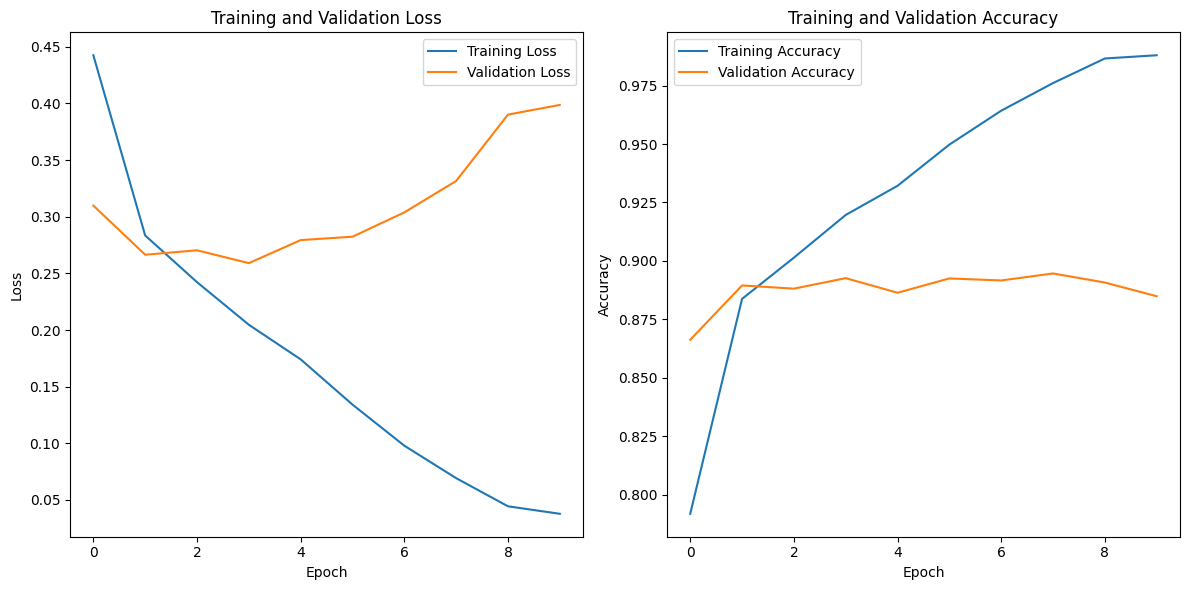

<Figure size 640x480 with 0 Axes>

In [126]:
import matplotlib.pyplot as plt
#Plotting the error
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
plt.savefig('/content/drive/My Drive/imbd_senti_analysis_model_history.png')

In [77]:
#Lets see a complete report
from sklearn.metrics import classification_report
y_pred = model.predict(X_test_padded)
y_pred = (y_pred > 0.5)
print(classification_report(y_test, y_pred))

313/313 [==============================] - 2s 4ms/step
              precision    recall  f1-score   support

           0       0.91      0.86      0.88      4961
           1       0.87      0.91      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [78]:
#Lets create a function for predicting positive, neutral and negative sentiment of a review based on the model
def predict_sentiment(review):
  #First preprocess and padding it
  preprocessed_review = preprocess_text(review)
  sequence = tokenizer.texts_to_sequences([preprocessed_review])
  padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)
  print("Review:" ,preprocessed_review)

  #Predict the sentiment
  sentiment_prediction = model.predict(padded_sequence)
  print("Prediction :",sentiment_prediction)
  if sentiment_prediction > 0.65:
    return 'Positive'
  elif sentiment_prediction < 0.40:
    return 'Negative'
  else:
    return 'Mixed'




In [101]:
##Now give a review
text="The movie was humurous and enlightening also."
print(predict_sentiment(text))

Review: the movi wa humur and enlighten also . great
1/1 [==============================] - 0s 22ms/step
Prediction : [[0.9932933]]
Positive


In [83]:
word_to_check = 'hokey'
if word_to_check in tokenizer.word_index:
    print(f"'{word_to_check}' is present in the tokenizer.")
else:
    print(f"'{word_to_check}' is not present in the tokenizer.")

'hokey' is present in the tokenizer.


**Making some Observations**

In [125]:
#Lets play with embedding just for fun
#Lets find top 10 similar words to some given word
word = 'what'
processed_word=stemmer.stem(word.lower())
print(processed_word)
similar_words = word2vec_model.wv.most_similar(processed_word, topn=100)
for word, similarity in similar_words:
    print(f"{word}: {similarity}")


what
how: 0.6830280423164368
whatev: 0.644677996635437
someth: 0.643673837184906
whi: 0.6382807493209839
that: 0.6214901804924011
everyth: 0.6060041189193726
anyth: 0.5600943565368652
thing: 0.5372591018676758
noth: 0.534087598323822
whether: 0.5234477519989014
just: 0.510444164276123
it: 0.49610915780067444
where: 0.4863929748535156
murder.what: 0.4822959303855896
actual: 0.46862170100212097
ambasitor: 0.46301817893981934
hermann.troubl: 0.4625317454338074
truth: 0.4570370614528656
.göta: 0.45457735657691956
thi: 0.44765475392341614
sorrowful.i: 0.4452519118785858
right: 0.4431026875972748
eeeee: 0.4416901171207428
hooker.for: 0.4412281811237335
boss/girlfriend: 0.4398457109928131
n't: 0.4336637556552887
becaus: 0.4331049919128418
mislead.it: 0.43243762850761414
other.what: 0.432273268699646
incorrect.thi: 0.4319361746311188
if: 0.43014851212501526
fantasy/fairytal: 0.428427129983902
realli: 0.4266957938671112
sponser: 0.42647168040275574
all: 0.4157547652721405
soon.what: 0.408768266